In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import librosa.display
import librosa
import numpy as np
import glob
import os
import math
import tensorflow as tf
from urllib.request import urlretrieve
import tarfile
from sklearn.decomposition import PCA

In [2]:
def indices_to_one_hot(dta):
    one_hot = np.zeros((len(dta), len(np.unique(dta))), np.uint8)
    one_hot[np.arange(len(dta)), dta] = 1
    return one_hot

def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")
        
def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

def uncompress(fname):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [3]:
weights_history = []

class GraphWeightsCallback(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs):
        weights, _biases = model.get_weights()
        w1, w2 = weights
        weights = [w1[0], w2[0]]
        print('on_batch_end() model.weights:', weights)
        weights_history.append(weights)


In [4]:
if not os.path.isdir('genres'):
    download('http://opihi.cs.uvic.ca/sound/genres.tar.gz', 'genres.tar.gz')
    uncompress('genres.tar.gz')
    !rm genres.tar.gz

In [5]:
sample_rate = 11025
sample_seconds = 5 # the samples are not even so trim them down
load_per_genre = 100 # anything less than two is invalid. We need testing and training for this to functionally work
testing_threshold = 0.25 # only really makes sense if you have 10 or more but anyway
training_count = load_per_genre - math.ceil(load_per_genre * testing_threshold)

number_of_epochs = 40
number_per_batch = 64

print(training_count)

75


In [6]:
all_file_paths = glob.glob(os.path.expanduser("genres/*/*.au"))
number_of_files = len(all_file_paths)
genres = sorted(list(set(file_path.split("/")[1] for file_path in all_file_paths)))

print("Song genres", genres)

Song genres ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [7]:
train_data_list = []
train_labels_list = []

test_data_list = []
test_labels_list = []

for genre in genres:
    genre_files = glob.glob(os.path.expanduser("genres/" + genre + "/*.au"))
    for i, audio_file_path in enumerate(genre_files):
        raw_samples_1, _ = librosa.core.load(audio_file_path, sample_rate, duration=sample_seconds)
        raw_samples_2, _ = librosa.core.load(audio_file_path, sample_rate, offset=10, duration=sample_seconds)

        flourier_transform_1 = librosa.stft(raw_samples_1, hop_length=200)
        flourier_transform_2 = librosa.stft(raw_samples_2, hop_length=200)


        if i <= training_count - 1:
            train_data_list.append(flourier_transform_1)
            train_labels_list.append(genres.index(genre))
            train_data_list.append(flourier_transform_2)
            train_labels_list.append(genres.index(genre))
        else:
            test_data_list.append(flourier_transform_1)
            test_labels_list.append(genres.index(genre))
            test_data_list.append(flourier_transform_2)
            test_labels_list.append(genres.index(genre))

        if load_per_genre and i >= load_per_genre - 1:
            break

x_train = np.array(train_data_list)
y_train = indices_to_one_hot(np.array(train_labels_list))

x_test = np.array(test_data_list)
y_test = indices_to_one_hot(np.array(test_labels_list))

print("train data", x_train.shape)
print("train labels", y_train.shape)

print("test data", x_test.shape)
print("test labels", y_test.shape)

train data (1500, 1025, 276)
train labels (1500, 10)
test data (500, 1025, 276)
test labels (500, 10)


(array([150., 150., 150., 150., 150., 150., 150., 150., 150., 150.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

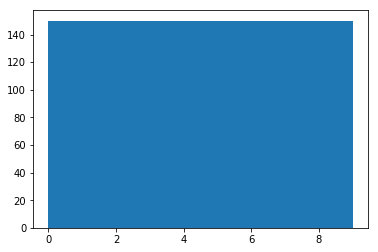

In [8]:
plt.hist(train_labels_list)

(array([50., 50., 50., 50., 50., 50., 50., 50., 50., 50.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

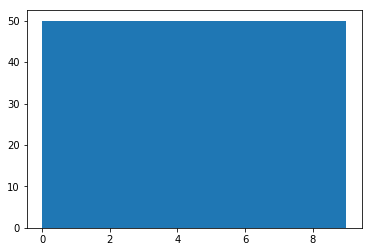

In [9]:
plt.hist(test_labels_list)

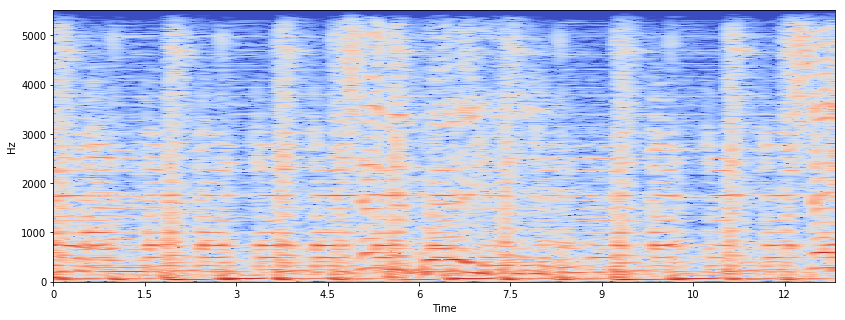

In [10]:
Xdb = librosa.amplitude_to_db(abs(x_train[10]))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')

In [11]:
# normalization
maximum = max(np.max(x_train), np.max(x_test))
normalized_x_train = x_train.astype('float32').reshape((*x_train.shape, 1)) / maximum
normalized_x_test = x_test.astype('float32').reshape((*x_test.shape, 1)) / maximum

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


In [12]:
np.max(normalized_x_train)

(0.99618757+0.061626602j)

In [13]:
print(normalized_x_train.shape)
print(normalized_x_test.shape)

(1500, 1025, 276, 1)
(500, 1025, 276, 1)


In [14]:
model = tf.keras.models.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=normalized_x_train[0].shape)) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

W0624 03:29:00.800692 139687267735296 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1025, 276, 64)     320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 138, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 138, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 138, 32)      8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 69, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 69, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 565248)            0

In [21]:
model.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(0.001),
             metrics=['accuracy'])

In [22]:
history = model.fit(normalized_x_train,
         y_train,
         batch_size=number_per_batch,
         epochs=number_of_epochs,
         validation_split=0.3)

Train on 1050 samples, validate on 450 samples
Epoch 1/25


/home/jupyter/.local/lib/python3.5/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


1050/1050 [==============================] - 91s 86ms/sample - loss: 0.0725 - acc: 0.9733 - val_loss: 16.8390 - val_acc: 0.2778
Epoch 2/25
1050/1050 [==============================] - 90s 85ms/sample - loss: 0.0675 - acc: 0.9857 - val_loss: 19.1133 - val_acc: 0.1911
Epoch 3/25
1050/1050 [==============================] - 89s 85ms/sample - loss: 0.0427 - acc: 0.9905 - val_loss: 20.0139 - val_acc: 0.0689
Epoch 4/25
1050/1050 [==============================] - 87s 83ms/sample - loss: 0.0497 - acc: 0.9876 - val_loss: 19.8424 - val_acc: 0.1111
Epoch 5/25
1050/1050 [==============================] - 87s 83ms/sample - loss: 0.0279 - acc: 0.9905 - val_loss: 24.8988 - val_acc: 0.0756
Epoch 6/25
1050/1050 [==============================] - 88s 84ms/sample - loss: 0.0396 - acc: 0.9838 - val_loss: 20.9632 - val_acc: 0.0644
Epoch 7/25
1050/1050 [==============================] - 88s 84ms/sample - loss: 0.0609 - acc: 0.9876 - val_loss: 23.1383 - val_acc: 0.0578
Epoch 8/25
1050/1050 [================

In [23]:
# Evaluate the model on test set
score = model.evaluate(normalized_x_test, y_test, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.41


Text(0, 0.5, 'loss')

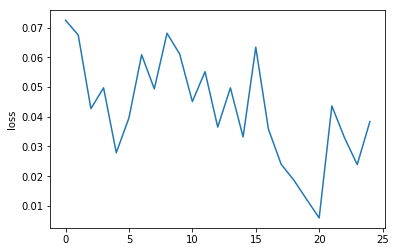

In [24]:
plt.plot(history.history['loss'])
plt.ylabel('loss')

Text(0, 0.5, 'Accuracy')

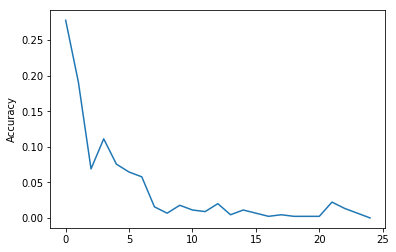

In [25]:
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')